# Comparing time series predictions of COVID-19 deaths

In [ ]:
!pip install pmdarima

In [3]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')


# Dataset Exploration

In [20]:
deaths_df = pd.read_csv('/content/time_series_covid19_deaths_global.csv')

In [21]:
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88


In [22]:
d = deaths_df.loc[:, '1/22/20':]
d.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88


In [23]:
d = d.transpose()
d.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Getting total death rate

In [24]:
d = d.sum(axis = 1)

In [25]:
d = d.to_list()

In [26]:
datasets = pd.DataFrame(columns=['ds', 'y'])

Get the dates from the columns in `deaths_df` data frame, starting from the fifth column. .

In [27]:
dates = list(deaths_df.columns[4:])

Convert the string dates into the datetime format, so that we can perform datetime operations on them

In [29]:
dates = list(pd.to_datetime(dates))

In [31]:
datasets['ds'] = dates
datasets['y'] = d

In [33]:
datasets = datasets.set_index('ds')

Let's plot the daily number of deaths


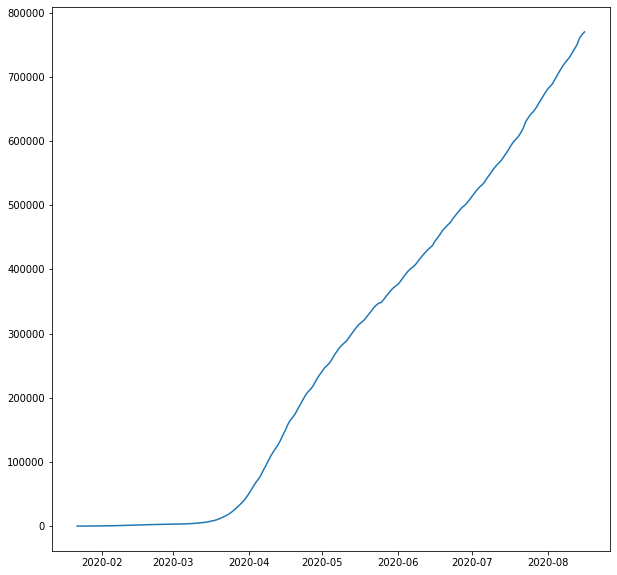

In [35]:
plt.figure(figsize=(10,10))
plt.plot(datasets)
plt.savefig('Cumulative daily deaths', bbox_inches='tight', transparent=False)

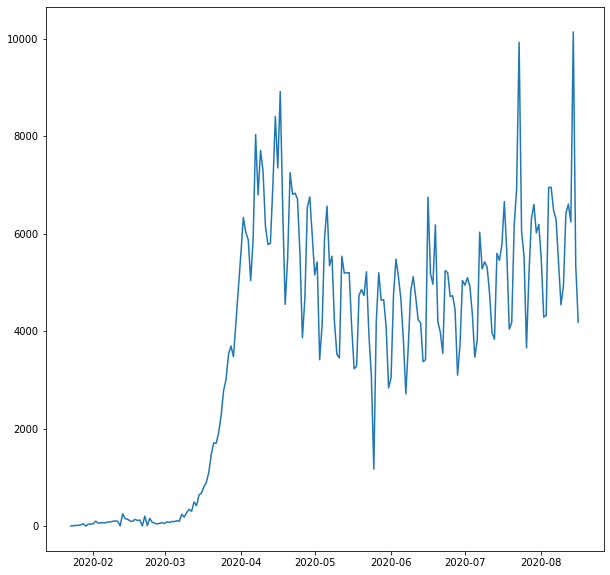

In [36]:
plt.figure(figsize=(10,10))
plt.plot(datasets.diff())
plt.savefig('Daily deaths', bbox_inches='tight', transparent=False)

In [37]:
datasets = datasets.diff()

In [45]:
datasets.head()

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0


In [48]:
datasets = datasets.loc['2020-01-23':'2020-08-13']

In [49]:
datasets.head()

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0


# Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

In [79]:
start_date = '2020-07-31'

train = datasets.loc[datasets.index < pd.to_datetime(start_date)]
test = datasets.loc[datasets.index >= pd.to_datetime(start_date)]

There are three hyperparameters that go into the order tuple: p, q and d. Here we've used p=2, q=1 and d=3.

In [52]:
model = SARIMAX(train, order = (2, 1, 3))

In [53]:
results = model.fit(disp=True)

In [68]:
sarimax_prediction = results.predict(
    start = start_date, end= '2020-08-13', dynamic= False)

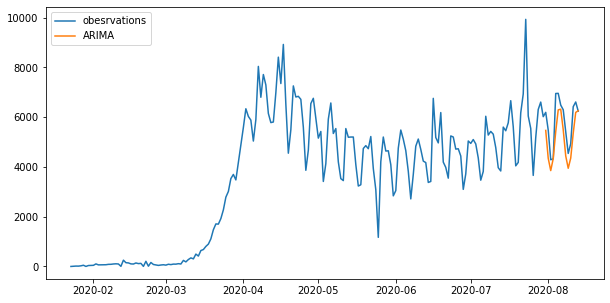

In [69]:
plt.figure(figsize=(10,5))
l1, = plt.plot(datasets, label='obesrvations')
l2, = plt.plot(sarimax_prediction, label= 'ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('sarimax prediction', bbox_inches='tight', transparent=False)

In [71]:
print('SARIMAX MAE = ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE =  650.6154682219609


In [65]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.414, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.847, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.308, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.720, Time=0.69 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

# Forcasting using Facebook's Prophet model

In [80]:
train.head()

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0


In [82]:
train['ds'] = train.index.values

In [83]:
train.head()

,y,ds
ds,,
2020-01-23,1.0,2020-01-23
2020-01-24,8.0,2020-01-24
2020-01-25,16.0,2020-01-25
2020-01-26,14.0,2020-01-26
2020-01-27,26.0,2020-01-27


In [84]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now let's forecast:

In [85]:
future = m.make_future_dataframe(periods=datasets.shape[0]-train.shape[0])
#future = m.make_future_dataframe(periods=test.shape[0])
prophet_prediction = m.predict(future)

Now let us calculate the mean absolute error for our predictions.

In [86]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= start_date]
print('Prophet MAE =', mean_absolute_error(prophet_future, test))

Prophet MAE = 571.8872860781038


Next, let's visualize the predictions.

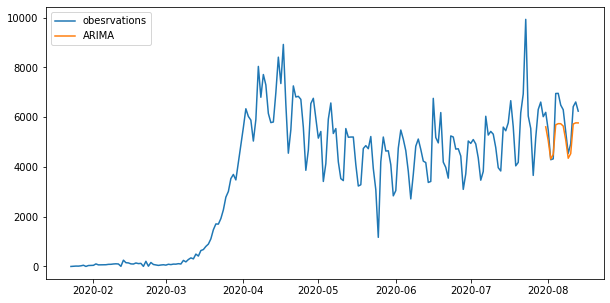

In [87]:
plt.figure(figsize=(10,5))
l1, = plt.plot(datasets, label='obesrvations')
l2, = plt.plot(prophet_future, label= 'ARIMA')
plt.legend(handles=[l1, l2])
plt.savefig('Prophet prediction', bbox_inches='tight', transparent=False)


# Preparing the dataset for XGBOOST and NN

In [90]:
def featurize(t):
  X= pd.DataFrame()

  X['day'] = t.index.day
  X['month'] = t.index.month
  X['quarter'] = t.index.quarter
  X['dayofweek'] = t.index.dayofweek
  X['dayofyear'] = t.index.dayofyear
  X['weekofyear'] = t.index.weekofyear
  y = t.y
  return X, y

featurize(datasets)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,23,1,1,3,23,4
1,24,1,1,4,24,4
2,25,1,1,5,25,4
3,26,1,1,6,26,4
4,27,1,1,0,27,5


# Create training and test datasets by splitting the dataset, and perform data normalization.

In [114]:
X_train, y_train = featurize(
    datasets.loc[datasets.index < pd.to_datetime(start_date)])
X_test, y_test = featurize(
    datasets.loc[datasets.index >= pd.to_datetime(start_date)])

In [115]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Apply the scaling to both the training and test sets, as follows.

In [120]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

# Train the XGBOOST and NN models

In [137]:
XGBOOST_model = XGBRegressor(n_estimators=50)

In [138]:
XGBOOST_model.fit(scaled_train, y_train,
                 eval_set= [(scaled_train, y_train), (scaled_test, y_test)],
                 verbose=True)
XGBOOST_prediction = XGBOOST_model.predict(scaled_test)

[13:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3926.27	validation_1-rmse:5364.15
[1]	validation_0-rmse:3563.2	validation_1-rmse:4909.52
[2]	validation_0-rmse:3234.76	validation_1-rmse:4536.32
[3]	validation_0-rmse:2939.88	validation_1-rmse:4200.33
[4]	validation_0-rmse:2674.4	validation_1-rmse:3862.47
[5]	validation_0-rmse:2439.07	validation_1-rmse:3591.74
[6]	validation_0-rmse:2223.52	validation_1-rmse:3261.25
[7]	validation_0-rmse:2030.4	validation_1-rmse:2963.19
[8]	validation_0-rmse:1855.85	validation_1-rmse:2740.28
[9]	validation_0-rmse:1700.05	validation_1-rmse:2505.91
[10]	validation_0-rmse:1559.18	validation_1-rmse:2295.18
[11]	validation_0-rmse:1434.67	validation_1-rmse:2149.84
[12]	validation_0-rmse:1322.91	validation_1-rmse:2003.42
[13]	validation_0-rmse:1221.68	validation_1-rmse:1821.29
[14]	validation_0-rmse:1132.53	validation_1-rmse:1640.87
[15]	validation_0-rmse:1051.37	

Let us calculate the mean absolute error for the training.

In [139]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE =  428.85062081473217


Creation and training of the feedforward neural network model.

In [140]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape = (scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer= Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
    scaled_test, y_test), epochs=220, verbose=1)
NN_prediction = NN_model.predict(scaled_test)

Epoch 1/220
6/6 [==============================] - 1s 48ms/step - loss: 3530.0448 - val_loss: 5792.5698
Epoch 2/220
6/6 [==============================] - 0s 5ms/step - loss: 3700.4306 - val_loss: 5792.5000
Epoch 3/220
6/6 [==============================] - 0s 7ms/step - loss: 3513.4459 - val_loss: 5792.4468
Epoch 4/220
6/6 [==============================] - 0s 6ms/step - loss: 3574.2622 - val_loss: 5792.3872
Epoch 5/220
6/6 [==============================] - 0s 6ms/step - loss: 3733.7494 - val_loss: 5792.3032
Epoch 6/220
6/6 [==============================] - 0s 5ms/step - loss: 3562.6728 - val_loss: 5792.2319
Epoch 7/220
6/6 [==============================] - 0s 6ms/step - loss: 3415.8822 - val_loss: 5792.1611
Epoch 8/220
6/6 [==============================] - 0s 7ms/step - loss: 3627.3137 - val_loss: 5791.9990
Epoch 9/220
6/6 [==============================] - 0s 6ms/step - loss: 3387.3722 - val_loss: 5791.8916
Epoch 10/220
6/6 [==============================] - 0s 6ms/step - loss: 

Let's compare the MAE values.

In [141]:
print('XGBOOST MAE = ', mean_absolute_error(XGBOOST_prediction, y_test))
print('Prophet MAE = ', mean_absolute_error(prophet_future, y_test))
print('XGBOOST MAE = ', mean_absolute_error(sarimax_prediction, y_test))
print('XGBOOST MAE = ', mean_absolute_error(NN_prediction, y_test))

XGBOOST MAE =  428.85062081473217
Prophet MAE =  571.8872860781038
XGBOOST MAE =  650.6154682219609
XGBOOST MAE =  725.4328962053571


Finally let us visualize the predictions of all 4 models.

<Figure size 1440x1440 with 0 Axes>

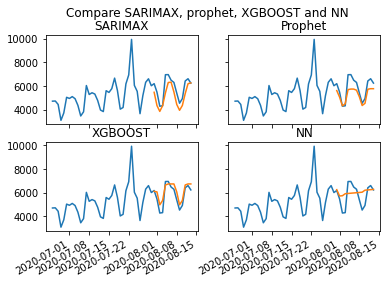

In [144]:

XGBOOST_df = pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(datasets.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(datasets.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(datasets.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(datasets.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)

***Deepak Kumar Singh***

***THANK YOU***